<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Rename-Columns" data-toc-modified-id="Rename-Columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Rename Columns</a></span></li><li><span><a href="#Extract-Year-and-Quarter-from-Dates" data-toc-modified-id="Extract-Year-and-Quarter-from-Dates-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Extract Year and Quarter from Dates</a></span></li><li><span><a href="#Calculate-Business-Duration-(Lifetime)" data-toc-modified-id="Calculate-Business-Duration-(Lifetime)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calculate Business Duration (Lifetime)</a></span></li><li><span><a href="#-Handle-Missinng-Data" data-toc-modified-id="-Handle-Missinng-Data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span> Handle Missinng Data</a></span></li><li><span><a href="#Calculate-Status-(Still-in-Business-or-Closed)" data-toc-modified-id="Calculate-Status-(Still-in-Business-or-Closed)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Calculate Status (Still in Business or Closed)</a></span></li><li><span><a href="#Lookup-Missing-Neighborhoods" data-toc-modified-id="Lookup-Missing-Neighborhoods-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Lookup Missing Neighborhoods</a></span></li><li><span><a href="#Fix-Date-Issues" data-toc-modified-id="Fix-Date-Issues-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Fix Date Issues</a></span></li><li><span><a href="#Create-a-Neighborhood-Size-Parameter" data-toc-modified-id="Create-a-Neighborhood-Size-Parameter-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Create a Neighborhood Size Parameter</a></span></li></ul></div>

<h3>Overview

This notebook contains data cleaning and feature engineering on the registered business dataset.

In [1]:
import pandas as pd
import numpy as np
import json
import ast
import os
import sys

module_path = os.path.abspath(os.path.join('./lib/'))

if module_path not in sys.path:   
    sys.path.append(module_path)
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import re
import time

%matplotlib inline

In [2]:
import datetime

def get_timestamp():
    #create timestamp for loggin and uniquely naming output files
    now = datetime.datetime.now()
    current_time_stamp = f'{now.year}'
    current_time_stamp += f'{now.year}'
    current_time_stamp += f'{now.month}'
    current_time_stamp += f'{now.day}'
    current_time_stamp += f'{now.second}'
    current_time_stamp += f'{now.microsecond}'
    return(current_time_stamp)

now = datetime.datetime.now()
this_year = now.year
this_month = now.month
if this_month < 4:
    this_quarter = 1
elif this_month < 7:
    this_quarter = 2
elif this_month < 10:
    this_quarter = 3
else:
    this_quarter = 4
this_year, this_quarter

(2019, 2)

<h3>Load Data

In [3]:
def reload():
    df = pd.read_csv('../tmp/conversion_201920195926880831.csv', low_memory=False)
    #convert dates
    df['dba_start'] = pd.to_datetime(df['dba_start']) 
    df['dba_end'] = pd.to_datetime(df['dba_end'])
    df['loc_start'] = pd.to_datetime(df['loc_start'])
    df['loc_end'] = pd.to_datetime(df['loc_end'])
    return df

In [4]:
df = reload()

In [5]:
df.shape

(195200, 27)

In [6]:
df.columns

Index(['business_zip', 'certificate_number', 'city', 'dba_name',
       'full_business_address', 'lic', 'lic_code_description', 'location',
       'mail_city', 'mail_state', 'mail_zipcode', 'mailing_address_1',
       'naic_code', 'naic_code_description',
       'neighborhoods_analysis_boundaries', 'ownership_name', 'parking_tax',
       'state', 'supervisor_district', 'transient_occupancy_tax', 'ttxid',
       'dba_start', 'dba_end', 'loc_start', 'loc_end', 'lat', 'lon'],
      dtype='object')

In [7]:
df.isnull().sum()

business_zip                            117
certificate_number                        0
city                                      0
dba_name                                  0
full_business_address                     2
lic                                  180860
lic_code_description                 181409
location                              51317
mail_city                             63429
mail_state                            65580
mail_zipcode                          63444
mailing_address_1                     65544
naic_code                             73598
naic_code_description                 73598
neighborhoods_analysis_boundaries     45809
ownership_name                            0
parking_tax                               0
state                                    14
supervisor_district                   45804
transient_occupancy_tax                   0
ttxid                                     0
dba_start                                 0
dba_end                         

<h3>Rename Columns

In [8]:
df = df.rename(columns={#'full_business_name':'bus_name',
                        'neighborhoods_analysis_boundaries': 'neighborhood',
                        'business_zip': 'zip',
                        #'naic_code': 'category'
                        #'supervisor_disctrict': 'sup_dist'
                           })
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,state,supervisor_district,transient_occupancy_tax,ttxid,dba_start,dba_end,loc_start,loc_end,lat,lon
0,94123.0,28,San Francisco,3101 Laguna Apts,3101 Laguna St,NaN,NaN,"{'latitude': '37.799823', 'longitude': '-122.4...",San Francisco,CA,...,CA,2.0,False,0000028-02-001,1993-09-30,NaT,1993-09-30,NaT,37.799823,-122.430996
1,94116.0,52,San Francisco,Ideal Novak Corp,8 Mendosa Ave,NaN,NaN,"{'latitude': '37.748926', 'longitude': '-122.4...",San Francisco,CA,...,CA,7.0,False,0000052-01-001,1968-10-01,NaT,1968-10-01,NaT,37.748926,-122.465074
2,94123.0,71,San Francisco,Tournahu Arms,1842 Jefferson St,NaN,NaN,"{'latitude': '37.804734', 'longitude': '-122.4...",San Francisco,CA,...,CA,NaN,False,0000071-01-001,1968-10-01,NaT,1968-10-01,2013-12-31,37.804734,-122.442997
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,NaN,NaN,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,CA,2.0,False,0000071-02-001,1968-10-01,NaT,1988-05-01,2013-12-31,37.800876,-122.444757
4,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,NaN,NaN,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,CA,2.0,False,0000071-02-003,1968-10-01,NaT,1988-05-01,2013-12-31,37.800876,-122.444757


In [9]:
df.sort_values(by='loc_end').tail()


,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,state,supervisor_district,transient_occupancy_tax,ttxid,dba_start,dba_end,loc_start,loc_end,lat,lon
195195,94103.0,1101546,San Francisco,Tehama Street Lofts,485 Tehama St 3,NaN,NaN,NaN,San Francisco,CA,...,CA,6.0,True,1220665-05-191,2019-05-01,NaT,2019-05-01,NaT,37.779541,-122.406176
195196,94115.0,947620,San Francisco,"Elizabeth A Whelchel, Ph.d.",1902 Webster St,NaN,NaN,NaN,San Francisco,CA,...,CA,2.0,False,1220668-05-191,1995-11-15,NaT,2019-05-04,NaT,37.788337,-122.432026
195197,94114.0,1078145,San Francisco,N/a,125 Romain Street St,NaN,NaN,NaN,San Francisco,CA,...,CA,8.0,False,1220669-05-191,2017-05-20,NaT,2017-05-30,NaT,37.756284,-122.440349
195198,94121.0,429057,San Francisco,Frisco Llc,3315 Clement St Apt 7,NaN,NaN,NaN,San Francisco,CA,...,CA,1.0,False,1220670-05-191,2008-05-21,NaT,2008-05-21,NaT,37.781337,-122.494861
195199,94112.0,1101547,San Francisco,Deepmachine Systems Corporation,153 College Ave,NaN,NaN,NaN,San Francisco,CA,...,CA,8.0,False,1220672-05-191,2019-05-01,NaT,2019-05-01,NaT,37.735506,-122.425999


In [10]:
df.isnull().sum()

zip                           117
certificate_number              0
city                            0
dba_name                        0
full_business_address           2
lic                        180860
lic_code_description       181409
location                    51317
mail_city                   63429
mail_state                  65580
mail_zipcode                63444
mailing_address_1           65544
naic_code                   73598
naic_code_description       73598
neighborhood                45809
ownership_name                  0
parking_tax                     0
state                          14
supervisor_district         45804
transient_occupancy_tax         0
ttxid                           0
dba_start                       0
dba_end                    129656
loc_start                       0
loc_end                    108869
lat                             0
lon                             0
dtype: int64

<h3>Extract Year and Quarter from Dates

In [11]:
# #Convert date into quarter string
def to_quarter(dt):
    try:
        dt = pd.Timestamp(dt)
        year = dt.year
        quarter = dt.quarter
    except:
        return 0, 0, None
    else:
        return year, quarter, f'{dt.year}-Q{dt.quarter}'

In [12]:
df[['y_start', 'q_start', 'yq_start']] = df.apply(lambda row: [0, 0, None] if pd.isnull(row.loc_start) 
                       else to_quarter(row.loc_start),
                       axis=1,  result_type='expand')
                       

In [13]:
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,ttxid,dba_start,dba_end,loc_start,loc_end,lat,lon,y_start,q_start,yq_start
0,94123.0,28,San Francisco,3101 Laguna Apts,3101 Laguna St,NaN,NaN,"{'latitude': '37.799823', 'longitude': '-122.4...",San Francisco,CA,...,0000028-02-001,1993-09-30,NaT,1993-09-30,NaT,37.799823,-122.430996,1993,3,1993-Q3
1,94116.0,52,San Francisco,Ideal Novak Corp,8 Mendosa Ave,NaN,NaN,"{'latitude': '37.748926', 'longitude': '-122.4...",San Francisco,CA,...,0000052-01-001,1968-10-01,NaT,1968-10-01,NaT,37.748926,-122.465074,1968,4,1968-Q4
2,94123.0,71,San Francisco,Tournahu Arms,1842 Jefferson St,NaN,NaN,"{'latitude': '37.804734', 'longitude': '-122.4...",San Francisco,CA,...,0000071-01-001,1968-10-01,NaT,1968-10-01,2013-12-31,37.804734,-122.442997,1968,4,1968-Q4
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,NaN,NaN,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,0000071-02-001,1968-10-01,NaT,1988-05-01,2013-12-31,37.800876,-122.444757,1988,2,1988-Q2
4,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,NaN,NaN,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,0000071-02-003,1968-10-01,NaT,1988-05-01,2013-12-31,37.800876,-122.444757,1988,2,1988-Q2


In [14]:
df[['y_end', 'q_end', 'yq_end']] = df.apply(lambda row: [0, 0, None] if pd.isnull(row.loc_end) 
                       else to_quarter(row.loc_end),
                       axis=1,  result_type='expand')

<h3>Calculate Business Duration (Lifetime)

In [15]:
#calculate how long a business has been open in quarters
def calc_duration(ys,qs,ye,qe):
    d =(ye-ys)*4
    d += (qe-qs)
    return int(d)

In [16]:
df['dur'] = df.apply(lambda row: -1 if pd.isnull(row.loc_end) 
                       else calc_duration(row.y_start,
                                          row.q_start,
                                          row.y_end,
                                          row.q_end),
                       axis=1)

In [17]:
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,loc_end,lat,lon,y_start,q_start,yq_start,y_end,q_end,yq_end,dur
0,94123.0,28,San Francisco,3101 Laguna Apts,3101 Laguna St,NaN,NaN,"{'latitude': '37.799823', 'longitude': '-122.4...",San Francisco,CA,...,NaT,37.799823,-122.430996,1993,3,1993-Q3,0.0,0.0,NaN,-1
1,94116.0,52,San Francisco,Ideal Novak Corp,8 Mendosa Ave,NaN,NaN,"{'latitude': '37.748926', 'longitude': '-122.4...",San Francisco,CA,...,NaT,37.748926,-122.465074,1968,4,1968-Q4,0.0,0.0,NaN,-1
2,94123.0,71,San Francisco,Tournahu Arms,1842 Jefferson St,NaN,NaN,"{'latitude': '37.804734', 'longitude': '-122.4...",San Francisco,CA,...,2013-12-31,37.804734,-122.442997,1968,4,1968-Q4,2013.0,4.0,2013-Q4,180
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,NaN,NaN,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,2013-12-31,37.800876,-122.444757,1988,2,1988-Q2,2013.0,4.0,2013-Q4,102
4,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,NaN,NaN,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,2013-12-31,37.800876,-122.444757,1988,2,1988-Q2,2013.0,4.0,2013-Q4,102


In [18]:
#save again
df.to_csv('../tmp/reg_bus_sfonly_clean_stg2_asof20190512.csv', index=False)

In [19]:
def reload():
    df = pd.read_csv('../tmp/reg_bus_sfonly_clean_stg2_asof20190512.csv', low_memory=False)
    #convert dates
    df['dba_start'] = pd.to_datetime(df['dba_start']) 
    df['dba_end'] = pd.to_datetime(df['dba_end'])
    df['loc_start'] = pd.to_datetime(df['loc_start'])
    df['loc_end'] = pd.to_datetime(df['loc_end'])
    return df

df = reload()

In [20]:
df.shape

(195200, 34)

<h3> Handle Missinng Data

In [21]:
df.isnull().sum()

zip                           117
certificate_number              0
city                            0
dba_name                        0
full_business_address           2
lic                        180860
lic_code_description       181409
location                    51317
mail_city                   63429
mail_state                  65580
mail_zipcode                63444
mailing_address_1           65544
naic_code                   73598
naic_code_description       73598
neighborhood                45809
ownership_name                  0
parking_tax                     0
state                          14
supervisor_district         45804
transient_occupancy_tax         0
ttxid                           0
dba_start                       0
dba_end                    129656
loc_start                       0
loc_end                    108869
lat                             0
lon                             0
y_start                         0
q_start                         0
yq_start      

In [22]:
missing_zip_mask = df.zip.isnull()

In [23]:
missing_zips = df[missing_zip_mask]
missing_zips.shape

(117, 34)

In [24]:
fill_cols = {'lic':'.', 'lic_code_description':'.',
                     'naic_code':'.','naic_code_description':'.',
                    'neighborhood':'.', 'supervisor_district':'.',
                    'zip':'.'
            }

In [25]:
df.fillna(fill_cols, inplace=True)

In [26]:
df.isnull().sum()

zip                             0
certificate_number              0
city                            0
dba_name                        0
full_business_address           2
lic                             0
lic_code_description            0
location                    51317
mail_city                   63429
mail_state                  65580
mail_zipcode                63444
mailing_address_1           65544
naic_code                       0
naic_code_description           0
neighborhood                    0
ownership_name                  0
parking_tax                     0
state                          14
supervisor_district             0
transient_occupancy_tax         0
ttxid                           0
dba_start                       0
dba_end                    129656
loc_start                       0
loc_end                    108869
lat                             0
lon                             0
y_start                         0
q_start                         0
yq_start      

In [27]:
df.shape

(195200, 34)

In [28]:
#save again
df.to_csv('../tmp/reg_bus_sfonly_clean_stg3_asof20190512.csv', index=False)

In [29]:
def reload():
    df = pd.read_csv('../tmp/reg_bus_sfonly_clean_stg3_asof20190512.csv', low_memory=False)
    #convert dates
    df['dba_start'] = pd.to_datetime(df['dba_start']) 
    df['dba_end'] = pd.to_datetime(df['dba_end'])
    df['loc_start'] = pd.to_datetime(df['loc_start'])
    df['loc_end'] = pd.to_datetime(df['loc_end'])
    return df

df = reload()

In [30]:
df.shape

(195200, 34)

In [31]:
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,loc_end,lat,lon,y_start,q_start,yq_start,y_end,q_end,yq_end,dur
0,94123.0,28,San Francisco,3101 Laguna Apts,3101 Laguna St,.,.,"{'latitude': '37.799823', 'longitude': '-122.4...",San Francisco,CA,...,NaT,37.799823,-122.430996,1993,3,1993-Q3,0.0,0.0,NaN,-1
1,94116.0,52,San Francisco,Ideal Novak Corp,8 Mendosa Ave,.,.,"{'latitude': '37.748926', 'longitude': '-122.4...",San Francisco,CA,...,NaT,37.748926,-122.465074,1968,4,1968-Q4,0.0,0.0,NaN,-1
2,94123.0,71,San Francisco,Tournahu Arms,1842 Jefferson St,.,.,"{'latitude': '37.804734', 'longitude': '-122.4...",San Francisco,CA,...,2013-12-31,37.804734,-122.442997,1968,4,1968-Q4,2013.0,4.0,2013-Q4,180
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,2013-12-31,37.800876,-122.444757,1988,2,1988-Q2,2013.0,4.0,2013-Q4,102
4,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,2013-12-31,37.800876,-122.444757,1988,2,1988-Q2,2013.0,4.0,2013-Q4,102


In [32]:
df['y_end'] = df['y_end'].replace(0, 9999)
df.y_end.head()

0    9999.0
1    9999.0
2    2013.0
3    2013.0
4    2013.0
Name: y_end, dtype: float64

<h3>Calculate Status (Still in Business or Closed)

In [33]:
df['status'] = df.apply(lambda row: 'open' if row.y_end >  9998 else 'closed', axis=1)

In [34]:
df.status.value_counts()

open      108869
closed     86331
Name: status, dtype: int64

In [35]:
df.dtypes


zip                                object
certificate_number                  int64
city                               object
dba_name                           object
full_business_address              object
lic                                object
lic_code_description               object
location                           object
mail_city                          object
mail_state                         object
mail_zipcode                       object
mailing_address_1                  object
naic_code                          object
naic_code_description              object
neighborhood                       object
ownership_name                     object
parking_tax                          bool
state                              object
supervisor_district                object
transient_occupancy_tax              bool
ttxid                              object
dba_start                  datetime64[ns]
dba_end                    datetime64[ns]
loc_start                  datetim

In [36]:
df['y_start'] = df['y_end'].astype('int64')
df['y_end'] = df['y_end'].astype('int64')
df['q_end'] = df['q_end'].astype('int64')

Look at the distribution of year end for closed businesses. Is the dataset very stale? Does it make sense to drop old businesses?

In [37]:
df['y_end'].describe()

count    195200.000000
mean       6468.267725
std        3964.922216
min        1918.000000
25%        2017.000000
50%        9999.000000
75%        9999.000000
max        9999.000000
Name: y_end, dtype: float64

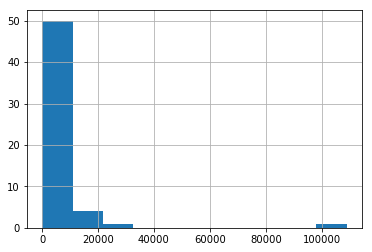

In [38]:
df['y_end'].value_counts().hist();

In [39]:
oldbusmask = df['y_end'] < 2004

In [40]:
df[~oldbusmask].status.value_counts()

open      108869
closed     86052
Name: status, dtype: int64

Create new dfs to look at older and more recent businesses

In [41]:
dfold = df[oldbusmask]

In [42]:
dfrecent = df[~oldbusmask]

In [43]:
dfold.shape

(279, 35)

In [44]:
dfrecent.shape

(194921, 35)

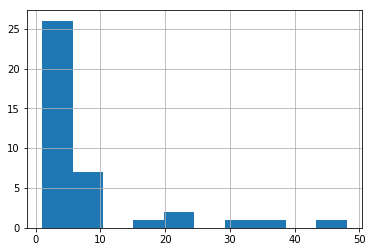

In [45]:
dfold['y_end'].value_counts().hist();

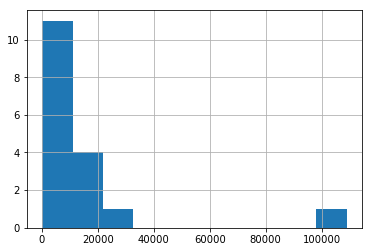

In [46]:
dfrecent['y_end'].value_counts().hist();

Do data quality checks on lat and lon

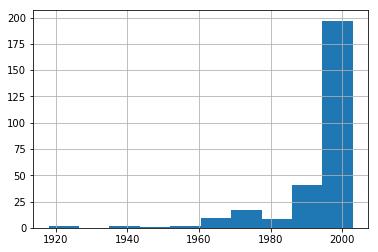

In [47]:
dfold['y_end'].hist();

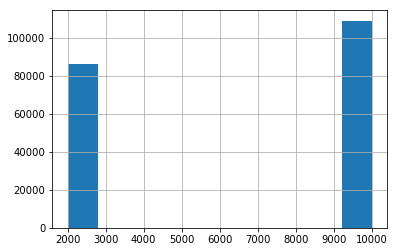

In [48]:
dfrecent['y_end'].hist();

The majority of the businesses that closed are recent, so no point in dropping them.

In [49]:
df.lon.describe()

count    195200.000000
mean       -122.390717
std           2.010854
min        -122.674068
25%        -122.440841
50%        -122.419315
75%        -122.403781
max         103.764938
Name: lon, dtype: float64

In [50]:
df.lat.describe()

count    195200.000000
mean         37.759519
std           0.608671
min           0.000000
25%          37.755929
50%          37.777197
75%          37.789429
max          47.615292
Name: lat, dtype: float64

Found an error with one, let's take a look

In [51]:
dfdq = df[df.lon > 0]

In [52]:
dfdq

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,lat,lon,y_start,q_start,yq_start,y_end,q_end,yq_end,dur,status
189171,94118.0,1096080,San Francisco,Amausaan Group,354 Clementi St,.,.,NaN,San Francisco,CA,...,1.316181,103.764938,9999,4,2018-Q4,9999,0,NaN,-1,open


In [53]:
#out of range point looked up and fixed manually
#354 Clementi St#0    POINT (-122.4194155 37.7749295)
#Name: geometry, dtype: object

In [54]:
import warnings
warnings.filterwarnings('ignore')
##this was

In [55]:
df[df.lon > 0].index[0]

189171

In [56]:
df['lat'].iloc[189171]=37.7749295
df['lon'].iloc[189171]=-122.4194155

In [57]:
df.iloc[189171]

zip                                    94118.0
certificate_number                     1096080
city                             San Francisco
dba_name                        Amausaan Group
full_business_address          354 Clementi St
lic                                          .
lic_code_description                         .
location                                   NaN
mail_city                        San Francisco
mail_state                                  CA
mail_zipcode                             94118
mailing_address_1              354 Clementi St
naic_code                            7220-7229
naic_code_description            Food Services
neighborhood                    Inner Richmond
ownership_name                  Amausaan Group
parking_tax                              False
state                                       CA
supervisor_district                        1.0
transient_occupancy_tax                  False
ttxid                           1207964-12-181
dba_start    

In [58]:
df.lat.describe()

count    195200.000000
mean         37.759705
std           0.603056
min           0.000000
25%          37.755929
50%          37.777197
75%          37.789429
max          47.615292
Name: lat, dtype: float64

In [59]:
df.lon.describe()

count    195200.000000
mean       -122.391876
std           1.944611
min        -122.674068
25%        -122.440841
50%        -122.419315
75%        -122.403781
max           0.000000
Name: lon, dtype: float64

In [60]:
#save again
df.to_csv('../tmp/reg_bus_sfonly_clean_stg4_asof20190512.csv', index=False)

In [61]:
def reload():
    df = pd.read_csv('../tmp/reg_bus_sfonly_clean_stg4_asof20190512.csv', low_memory = False)
    #convert dates
    df['dba_start'] = pd.to_datetime(df['dba_start']) 
    df['dba_end'] = pd.to_datetime(df['dba_end'])
    df['loc_start'] = pd.to_datetime(df['loc_start'])
    df['loc_end'] = pd.to_datetime(df['loc_end'])
    return df

df = reload()

In [62]:
df.shape

(195200, 35)

<h3>Lookup Missing Neighborhoods

Open Data SF provides an API for looking up neighborhood names by  geo coordinates. I used code from this source: https://github.com/dylburger/sf-lat-long-mapper , imported as latlong.py, to as a helper function. In the future I will incorporate it into my Sodapy reader class. 

After manually iterating through the geocoordinate lookup process, I took a different approach with neighborhoods. I put the rows with missing neighborhoods into a dataframe and broke it into chunks so I could do the lookup in batches, and save along the way. This still takes a bit of time. I will use a table store and lookup for this process as well, in future versions of this project.

In [64]:
df.neighborhood.value_counts()

.                                 45809
Financial District/South Beach    21974
Mission                           11559
South of Market                    8871
Sunset/Parkside                    7807
Bayview Hunters Point              6341
Outer Richmond                     5501
Marina                             5266
Chinatown                          4994
Nob Hill                           4617
West of Twin Peaks                 4615
Castro/Upper Market                4410
Tenderloin                         4389
Pacific Heights                    4376
Hayes Valley                       4145
Potrero Hill                       3772
Inner Sunset                       3532
Noe Valley                         3500
Inner Richmond                     3478
Bernal Heights                     3423
North Beach                        3293
Russian Hill                       3208
Haight Ashbury                     3057
Western Addition                   3038
Excelsior                          2652


In [65]:
set(df.neighborhood)

{'.',
 'Bayview Hunters Point',
 'Bernal Heights',
 'Castro/Upper Market',
 'Chinatown',
 'Excelsior',
 'Financial District/South Beach',
 'Glen Park',
 'Golden Gate Park',
 'Haight Ashbury',
 'Hayes Valley',
 'Inner Richmond',
 'Inner Sunset',
 'Japantown',
 'Lakeshore',
 'Lincoln Park',
 'Lone Mountain/USF',
 'Marina',
 'McLaren Park',
 'Mission',
 'Mission Bay',
 'Nob Hill',
 'Noe Valley',
 'North Beach',
 'Oceanview/Merced/Ingleside',
 'Outer Mission',
 'Outer Richmond',
 'Pacific Heights',
 'Portola',
 'Potrero Hill',
 'Presidio',
 'Presidio Heights',
 'Russian Hill',
 'Seacliff',
 'South of Market',
 'Sunset/Parkside',
 'Tenderloin',
 'Treasure Island',
 'Twin Peaks',
 'Visitacion Valley',
 'West of Twin Peaks',
 'Western Addition'}

In [66]:
dfmissingnmask = df['neighborhood'] == '.'

In [67]:
dfmissingn = df[dfmissingnmask]

In [68]:
dfmissingn.shape

(45809, 35)

In [69]:
dfnotmissing = df[~dfmissingnmask]

In [70]:
dfnotmissing.shape

(149391, 35)

In [71]:
dfnotmissing.shape[0] + dfmissingn.shape[0]

195200

In [72]:
#split it into groups of 5000 each
dfgr1 = dfmissingn[:5000]
dfgr2 = dfmissingn[5000:10000]
dfgr3 = dfmissingn[10000:15000]
dfgr4 = dfmissingn[15000:20000]
dfgr5 = dfmissingn[20000:25000]
dfgr6 = dfmissingn[25000:30000]
dfgr7 = dfmissingn[30000:35000]
dfgr8 = dfmissingn[35000:40000]
dfgr9 = dfmissingn[40000:45000]
dfgr10 = dfmissingn[45000:]

I found code to use another DataSF dataset to translate coordinates into neighborhoods
https://github.com/dylburger/sf-lat-long-mapper
I modified it to use my credentials

In [73]:
from LatLong import *

NOTE: This codea 

In [74]:
def get_neighborhood(lat,lon):
    try:
        ll = LatLong(lat,lon)
        neighborhood = ll.get_neighborhood()
    except:
        print(f'error returned from LatLong')
        return None
    else:
        print(f'found neighborhood {neighborhood}')
        return neighborhood

Note: The neighborhood translation itself is resource intensive and the data has already been saved. This is the code that was used: 

```
start_execution = time.time()
dfgr1['new_neighborhood'] = dfgr1.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr1.to_csv('../tmp/neighborhood_group1.csv', index=False)

start_execution = time.time()
dfgr2['new_neighborhood'] = dfgr2.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr2.to_csv('../tmp/neighborhood_group2.csv', index=False)

start_execution = time.time()
dfgr3['new_neighborhood'] = dfgr3.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr3.to_csv('../tmp/neighborhood_group3.csv', index=False)

start_execution = time.time()
dfgr4['new_neighborhood'] = dfgr4.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr4.to_csv('../tmp/neighborhood_group4.csv', index=False)

start_execution = time.time()
dfgr5['new_neighborhood'] = dfgr5.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr5.to_csv('../tmp/neighborhood_group5.csv', index=False)

start_execution = time.time()
dfgr6['new_neighborhood'] = dfgr6.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr6.to_csv('../tmp/neighborhood_group6.csv', index=False)

start_execution = time.time()
dfgr7['new_neighborhood'] = dfgr7.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr7.to_csv('../tmp/neighborhood_group7.csv', index=False)

start_execution = time.time()
dfgr8['new_neighborhood'] = dfgr8.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr8.to_csv('../tmp/neighborhood_group8.csv', index=False)

start_execution = time.time()
dfgr9['new_neighborhood'] = dfgr9.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr9.to_csv('../tmp/neighborhood_group9.csv', index=False)

start_execution = time.time()
dfgr10['new_neighborhood'] = dfgr10.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)
end_execution = time.time()
print(f'Elapsed time: {end_execution - start_execution}')

dfgr10.to_csv('../tmp/neighborhood_group10.csv', index=False)

#dfnotmissing['new_neighborhood'] =  dfnotmissing['neighborhood']
dfnotmissing['new_neighborhood'] = dfnotmissing.apply(lambda row: row.neighborhood if row.neighborhood != '.' else 
                                  get_neighborhood(row.lat, row.lon),
                                  axis=1)



dfsubsets = [dfnotmissing, dfgr1, dfgr2, dfgr3, dfgr4, dfgr5, 
             dfgr6, dfgr7, dfgr8, dfgr9, dfgr10]

dffixed = pd.concat(dfsubsets)

dfnotmissing.shape

dffixed.shape

dffixed.new_neighborhood.value_counts()

#testmask = dffixed['new_neighborhood'] == 'South of Market'
testmask = dffixed['new_neighborhood'].isna()


#save again
dffixed.to_csv('../tmp/reg_bus_sfonly_clean_stg5_asof20190510.csv', index=False)

```

dffixed[testmask].shape

#because I returned None when neighborhood couldn't be found

dffixed.fillna({'new_neighborhood':'.'}, inplace=True)

dffixed.isnull().sum()

#save again
dffixed.to_csv('../tmp/reg_bus_sfonly_clean_stg5_asof20190512.csv', index=False)

<h3>Fix Date Issues

Some rows had a start date that was earlier in time than the end date. The following block of code explores possible reasons for that and determines that it is likely they were reversed, and that swapping them is reasonable, and a better solution than dropping the rows.

In [77]:
df = pd.read_csv('../tmp/reg_bus_sfonly_clean_stg5_asof20190512.csv', low_memory = False)
  

In [78]:
openstillmask = (df.loc_end.isnull())
closed = df[~openstillmask]

In [79]:
closed.shape

(86331, 36)

In [80]:
# closed.apply(lambda x: print(x.loc_start, x.loc_end, x.dba_start, x.dba_end, x.neighborhood, x.naic_code)
#               if x.loc_start > x.loc_end else None, axis=1)

In [81]:
dfdatediffs = pd.DataFrame(columns=['ys', 'ye', 'dbas', 'dbae', 'n', 'naic'])
dfdatediffs[['ys', 'ye', 'dbas', 'dbae', 'n', 'naic']] = closed.apply(lambda x: 
                           (x.y_start, x.y_end, x.dba_start, x.dba_end, x.neighborhood, x.naic_code)
             if x.y_start > x.y_end else (None, None, None, None, None, None), axis=1, result_type='expand')

In [82]:
dfdatediffs.shape

(86331, 6)

In [83]:
dfdatediffs.dropna(inplace=True)

In [84]:
dfdatediffs.shape

(366, 6)

In [85]:
dfdatediffs.dtypes

ys      float64
ye      float64
dbas     object
dbae     object
n        object
naic     object
dtype: object

In [87]:
dfdatediffs['dbas'] = pd.to_datetime(dfdatediffs['dbas']) 
dfdatediffs['dbae'] = pd.to_datetime(dfdatediffs['dbae'])

In [88]:
dfdatediffs['dbas'] = dfdatediffs.apply(lambda x: x['dbas'].year, axis=1)
dfdatediffs['dbae'] = dfdatediffs.apply(lambda x: x['dbae'].year, axis=1)

In [89]:
dfdatediffs.reset_index(inplace=True)
dfdatediffs.head(30)

,index,ys,ye,dbas,dbae,n,naic
0,1750,1976.0,1968.0,1968,1968,Lone Mountain/USF,5300-5399
1,1751,1993.0,1968.0,1968,1968,Inner Richmond,5300-5399
2,1752,1999.0,1968.0,1968,1968,Lone Mountain/USF,5300-5399
3,3258,2009.0,1968.0,1968,2015,Financial District/South Beach,5300-5399
4,3637,1979.0,1970.0,1979,2017,Financial District/South Beach,5300-5399
5,6143,2012.0,2009.0,1976,2009,Financial District/South Beach,.
6,9517,2012.0,2010.0,1985,2010,Mission,.
7,10233,2013.0,1990.0,1987,1990,Russian Hill,.
8,11920,2002.0,1992.0,1989,1992,Financial District/South Beach,.
9,14095,2001.0,2000.0,1991,2000,Mission,.


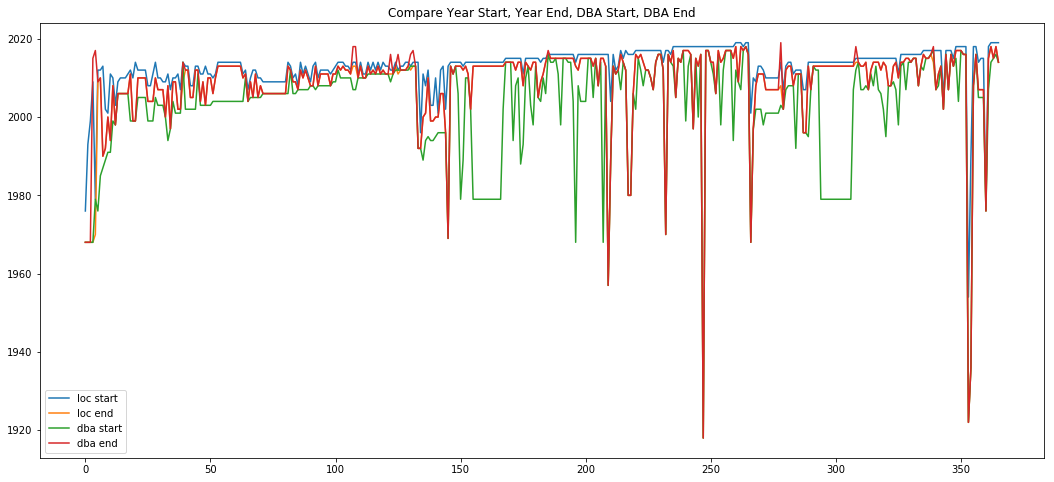

In [90]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)
#dem = (data["democracy"] == "Democracy")
#kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax.plot(dfdatediffs.ys)
ax.plot(dfdatediffs.ye)
ax.plot(dfdatediffs.dbas)
ax.plot(dfdatediffs.dbae)
ax.set_title('Compare Year Start, Year End, DBA Start, DBA End');
ax.legend(labels=['loc start', 'loc end', 'dba start', 'dba end'])

Inspection of the dates
If we were to assume the start and end dates were swapped, we see that the new location start an end period fits within the dba period, and so seems like a valid period. Rather than lose these 80 rows, which do contain additional feature information (naic and neighborhood), we will swap the dates on loc start and end dates on these rows.

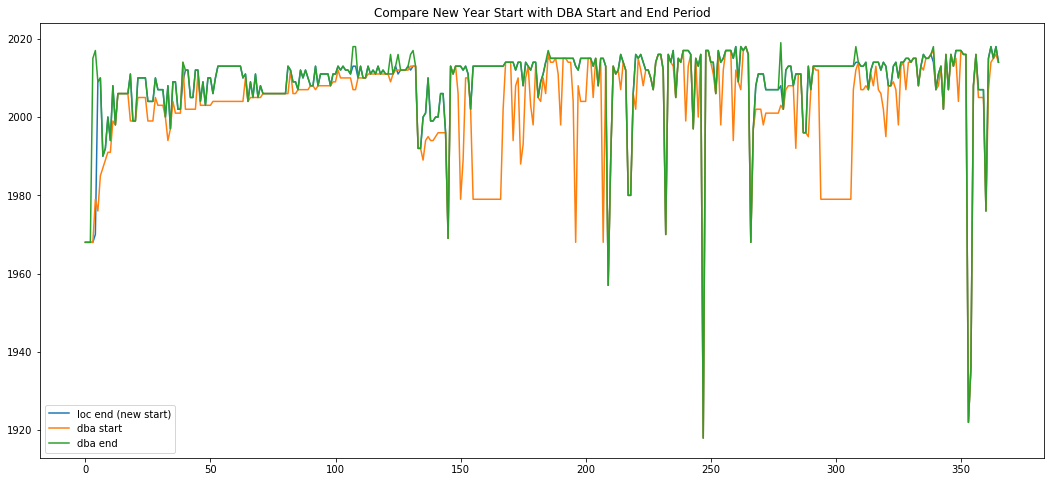

In [91]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)
#dem = (data["democracy"] == "Democracy")
#kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
#ax.plot(dfdatediffs.ys)
ax.plot(dfdatediffs.ye)
ax.plot(dfdatediffs.dbas)
ax.plot(dfdatediffs.dbae)
ax.set_title('Compare New Year Start with DBA Start and End Period');
ax.legend(labels=['loc end (new start)', 'dba start', 'dba end'])

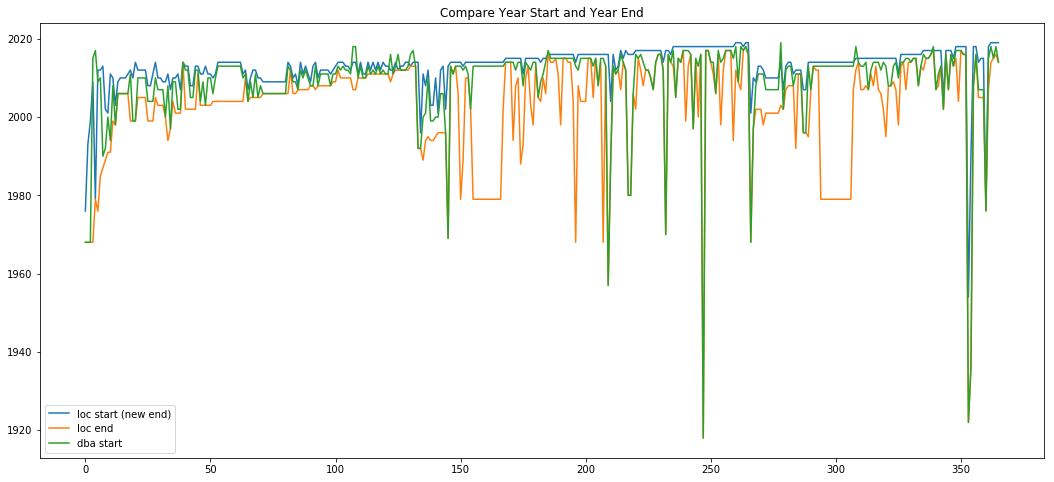

In [92]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)
#dem = (data["democracy"] == "Democracy")
#kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax.plot(dfdatediffs.ys)
#ax.plot(dfdatediffs.ye)
ax.plot(dfdatediffs.dbas)
ax.plot(dfdatediffs.dbae)
ax.set_title('Compare Year Start and Year End');
ax.legend(labels=['loc start (new end)', 'loc end', 'dba start', 'dba end'])

In [93]:
dftest = pd.DataFrame(columns=['y_start', 'y_end'])
dftest[['y_start', 'y_end']] = df.apply(lambda row: [row.y_end, row.y_start] 
                                        if ((row.status == 'closed')  & (row.y_start > row.y_end))
                                        else [row.y_start, row.y_end], 
                                        axis=1, result_type='expand')

In [94]:
dftest.head(30)

,y_start,y_end
0,1993,9999
1,1968,9999
2,1988,2013
3,1988,2013
4,1968,2016
5,2013,2016
6,1968,9999
7,2012,9999
8,2013,9999
9,1968,9999


In [95]:
dftest['check'] = dftest['y_end'] - dftest['y_start']

In [96]:
dftest.check.value_counts()

1       12163
7981    11716
0       11112
7982    10315
7983     9932
7984     9525
2        9034
7985     8994
3        6631
4        5902
7986     5854
5        5481
7987     4996
6        4855
7988     4484
7        4317
7992     3838
7980     3832
7989     3546
8        3475
11       3390
7990     3078
9        2806
7991     2758
10       2623
7993     2396
7994     2179
7995     2172
12       1872
7996     1689
        ...  
8103        2
8086        1
69          1
8063        1
8056        1
8057        1
8059        1
8089        1
8039        1
8070        1
100         1
8069        1
8150        1
8075        1
70          1
68          1
8062        1
67          1
8129        1
8079        1
8090        1
8093        1
8102        1
60          1
8076        1
8120        1
8083        1
8108        1
54          1
127         1
Name: check, Length: 174, dtype: int64

In [97]:
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,lon,y_start,q_start,yq_start,y_end,q_end,yq_end,dur,status,new_neighborhood
0,94123.0,28,San Francisco,3101 Laguna Apts,3101 Laguna St,.,.,"{'latitude': '37.799823', 'longitude': '-122.4...",San Francisco,CA,...,-122.430996,1993,3,1993-Q3,9999,0,NaN,-1,open,Marina
1,94116.0,52,San Francisco,Ideal Novak Corp,8 Mendosa Ave,.,.,"{'latitude': '37.748926', 'longitude': '-122.4...",San Francisco,CA,...,-122.465074,1968,4,1968-Q4,9999,0,NaN,-1,open,West of Twin Peaks
2,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,-122.444757,1988,2,1988-Q2,2013,4,2013-Q4,102,closed,Marina
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,-122.444757,1988,2,1988-Q2,2013,4,2013-Q4,102,closed,Marina
4,94133.0,86,San Francisco,1601 Grant Apts,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,-122.407812,1968,4,1968-Q4,2016,2,2016-Q2,190,closed,North Beach


In [98]:
df[['loc_start', 'loc_end']] = df.apply(lambda row: [row.loc_end, row.loc_start] 
                                        if ((row.status == 'closed')  & (row.y_start > row.y_end))
                                        else [row.loc_start, row.loc_end], 
                                        axis=1, result_type='expand')

In [99]:
df[['y_start', 'y_end']] = df.apply(lambda row: [row.y_end, row.y_start] 
                                        if ((row.status == 'closed')  & (row.y_start > row.y_end))
                                        else [row.y_start, row.y_end], 
                                        axis=1, result_type='expand')

In [101]:
#calculate how long a business has been open in quarters
def calc_duration(ys,qs,ye,qe):
    if ye > 9998:
        ye = this_year
        qe = this_quarter
    d = (ye-ys)*4
    d += (qe-qs)
    if d < 0:
        d = int(abs(d))
    return int(d)

In [102]:
df['dur'] = df.apply(lambda row: calc_duration(row.y_start,
                                          row.q_start,
                                          row.y_end,
                                          row.q_end),
                       axis=1)

In [104]:
#save again
df.to_csv('../tmp/reg_bus_sfonly_clean_stg6_asof20190515.csv', index=False)

In [105]:
df = pd.read_csv('../tmp/reg_bus_sfonly_clean_stg6_asof20190515.csv', low_memory = False)


<h3>Create a Neighborhood Size Parameter

Using value_counts(), bin the number of records to allow us to assign a new variable to act as a proxy for business density.

In [106]:
bus_count = df.new_neighborhood.value_counts().to_frame()
bus_count

,new_neighborhood
Financial District/South Beach,21974
Mission,14171
South of Market,12861
Sunset/Parkside,7807
Outer Richmond,6365
Bayview Hunters Point,6341
Chinatown,6076
Marina,5897
Tenderloin,5535
Pacific Heights,5411


Create bins. 25 is an arbitraty number. The 25 bins eventually get combined into three categories, but starting with 25 allows for tweaking this level of granularity later.

In [119]:
lower, higher = bus_count['new_neighborhood'].min(), bus_count['new_neighborhood'].max()
n_bins = 25

In [120]:
lower = lower.astype(int)
higher = higher.astype(int)

In [121]:
val = ((higher - lower)/n_bins).astype(int)
edges = range(lower, higher, val) # the number of edges is 8
labels = ['(%d, %d]'%(edges[i], edges[i+1]) for i in range(len(edges)-1)]

In [122]:
bus_count['binned'] = pd.cut(bus_count.new_neighborhood, bins=n_bins, labels=labels, include_lowest=True)

In [123]:
pd.set_option('display.max_rows', 250)
bus_count.sort_values(by='binned', inplace=True)
bus_count

,new_neighborhood,binned,neighborhood,count
Lone Mountain,252,"(2, 880]",Lone Mountain,252
Diamond Heights,102,"(2, 880]",Diamond Heights,102
Oceanview,104,"(2, 880]",Oceanview,104
Upper Market,109,"(2, 880]",Upper Market,109
Sunnyside,110,"(2, 880]",Sunnyside,110
India Basin,111,"(2, 880]",India Basin,111
Candlestick Point SRA,115,"(2, 880]",Candlestick Point SRA,115
Apparel City,116,"(2, 880]",Apparel City,116
Presidio Terrace,120,"(2, 880]",Presidio Terrace,120
Holly Park,121,"(2, 880]",Holly Park,121


In [124]:
bus_count['neighborhood'] = bus_count.index
bus_count['count'] = bus_count.new_neighborhood
bus_count.sort_values(by='count', ascending=False, inplace=True)

In [125]:
bins = set(bus_count.binned)
bins

{'(12294, 13172]',
 '(14050, 14928]',
 '(1758, 2636]',
 '(2, 880]',
 '(21074, 21952]',
 '(2636, 3514]',
 '(3514, 4392]',
 '(4392, 5270]',
 '(5270, 6148]',
 '(6148, 7026]',
 '(7026, 7904]',
 '(880, 1758]'}

In [126]:
def set_neighborhood_type(d, row):
    if row.binned == '(2, 880]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Sparse'  }
        
    if row.binned == '(880, 1758]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Medium'  }
    if row.binned == '(1758, 2636]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Medium'  }
    if row.binned == '(2636, 3514]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Medium'  }
    if row.binned == '(3514, 4392]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Medium'  }   
    if row.binned == '(4392, 5270]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Medium'  }
    if row.binned == '(5270, 6148]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Medium'  }
    if row.binned == '(6148, 7026]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Medium'  }
    if row.binned == '(7026, 7904]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Medium'  }
 
    if row.binned == '(12294, 13172]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Dense'  }
    if row.binned == '(14050, 14928]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Dense'  }
    if row.binned == '(21074, 21952]':
        d[row.neighborhood] = { 'bin': row.binned, 'size': 'Dense'  }

        
   

Create a dictionary to store the bin size and the category mapping. The category will then be added to the registered businesses dataset.

In [127]:
sf_neibhborhood_dict = {}
bus_count.apply(lambda row: set_neighborhood_type(sf_neibhborhood_dict,row), axis=1)
sf_neibhborhood_dict

{'Financial District/South Beach': {'bin': '(21074, 21952]', 'size': 'Dense'},
 'Mission': {'bin': '(14050, 14928]', 'size': 'Dense'},
 'South of Market': {'bin': '(12294, 13172]', 'size': 'Dense'},
 'Sunset/Parkside': {'bin': '(7026, 7904]', 'size': 'Medium'},
 'Outer Richmond': {'bin': '(6148, 7026]', 'size': 'Medium'},
 'Bayview Hunters Point': {'bin': '(6148, 7026]', 'size': 'Medium'},
 'Chinatown': {'bin': '(5270, 6148]', 'size': 'Medium'},
 'Marina': {'bin': '(5270, 6148]', 'size': 'Medium'},
 'Tenderloin': {'bin': '(5270, 6148]', 'size': 'Medium'},
 'Pacific Heights': {'bin': '(5270, 6148]', 'size': 'Medium'},
 'Nob Hill': {'bin': '(4392, 5270]', 'size': 'Medium'},
 'Financial District': {'bin': '(4392, 5270]', 'size': 'Medium'},
 'West of Twin Peaks': {'bin': '(4392, 5270]', 'size': 'Medium'},
 'Potrero Hill': {'bin': '(4392, 5270]', 'size': 'Medium'},
 'Inner Richmond': {'bin': '(4392, 5270]', 'size': 'Medium'},
 'North Beach': {'bin': '(4392, 5270]', 'size': 'Medium'},
 'Haye

In [128]:
#test
sf_neibhborhood_dict['North Beach']['size']


'Medium'

In [135]:
def add_neighborhood_size(d,n):
    size = d[n]['size']
    #print(size)
    return(size)

In [136]:
res = df['neighborhood_size'] = df.apply(lambda row: add_neighborhood_size(sf_neibhborhood_dict, row.new_neighborhood), axis=1)

In [137]:
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,y_start,q_start,yq_start,y_end,q_end,yq_end,dur,status,new_neighborhood,neighborhood_size
0,94123.0,28,San Francisco,3101 Laguna Apts,3101 Laguna St,.,.,"{'latitude': '37.799823', 'longitude': '-122.4...",San Francisco,CA,...,1993,3,1993-Q3,9999,0,NaN,103,open,Marina,Medium
1,94116.0,52,San Francisco,Ideal Novak Corp,8 Mendosa Ave,.,.,"{'latitude': '37.748926', 'longitude': '-122.4...",San Francisco,CA,...,1968,4,1968-Q4,9999,0,NaN,202,open,West of Twin Peaks,Medium
2,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,1988,2,1988-Q2,2013,4,2013-Q4,102,closed,Marina,Medium
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,1988,2,1988-Q2,2013,4,2013-Q4,102,closed,Marina,Medium
4,94133.0,86,San Francisco,1601 Grant Apts,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,1968,4,1968-Q4,2016,2,2016-Q2,190,closed,North Beach,Medium


In [138]:
df.neighborhood_size.value_counts()

Medium    127689
Dense      49006
Sparse     18505
Name: neighborhood_size, dtype: int64

In [139]:
#save again
df.to_csv('../tmp/reg_bus_sfonly_clean_stg7_asof20190515.csv', index=False)

In [140]:
df = pd.read_csv('../tmp/reg_bus_sfonly_clean_stg7_asof20190515.csv', low_memory = False)

In [141]:
###one more thing to do....  reconvert quarter to fix those that had been swapped

In [142]:
# #Convert date into quarter string
def to_quarter_only(dt):
    try:
        dt = pd.Timestamp(dt)
        year = dt.year
        quarter = dt.quarter
    except:
        return 0, 0, None
    else:
        return quarter, f'{dt.year}-Q{dt.quarter}'

In [143]:
df[['q_start', 'yq_start']] = df.apply(lambda row: [0, None] if pd.isnull(row.loc_start) 
                       else to_quarter_only(row.loc_start),
                       axis=1,  result_type='expand')
                       

In [144]:
df[['q_end', 'yq_end']] = df.apply(lambda row: [0, None] if pd.isnull(row.loc_end) 
                       else to_quarter_only(row.loc_end),
                       axis=1,  result_type='expand')

In [145]:
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,y_start,q_start,yq_start,y_end,q_end,yq_end,dur,status,new_neighborhood,neighborhood_size
0,94123.0,28,San Francisco,3101 Laguna Apts,3101 Laguna St,.,.,"{'latitude': '37.799823', 'longitude': '-122.4...",San Francisco,CA,...,1993,3,1993-Q3,9999,0.0,NaN,103,open,Marina,Medium
1,94116.0,52,San Francisco,Ideal Novak Corp,8 Mendosa Ave,.,.,"{'latitude': '37.748926', 'longitude': '-122.4...",San Francisco,CA,...,1968,4,1968-Q4,9999,0.0,NaN,202,open,West of Twin Peaks,Medium
2,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,1988,2,1988-Q2,2013,4.0,2013-Q4,102,closed,Marina,Medium
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,1988,2,1988-Q2,2013,4.0,2013-Q4,102,closed,Marina,Medium
4,94133.0,86,San Francisco,1601 Grant Apts,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,1968,4,1968-Q4,2016,2.0,2016-Q2,190,closed,North Beach,Medium


In [146]:
#save again
df.to_csv('../tmp/reg_bus_sfonly_clean_stg8_asof20190515.csv', index=False)